In [1]:
from xgboost import XGBClassifier
import pandas as pd
from pandas import DataFrame
from sklearn.metrics import RocCurveDisplay, roc_curve

params = {
    "random_state": 6,
}

In [2]:
def feature_engineering(raw_df: DataFrame) -> DataFrame:
    df = raw_df.copy()
    df.drop(columns=["Status", "Age Group"], inplace=True)

    # String join is used instead of replace due to some columns having more than one blank space between words.
    cols = ["_".join(column.split()).lower() for column in df.columns]
    df.columns = cols

    # tariff_plan has binary values with 1 and 2, changing into 1 and 0
    df["tariff_plan"] = df["tariff_plan"].replace(2, 0)

    # Use average per month metrics
    df["use_per_month"] = df.seconds_of_use / df.subscription_length
    df["calls_per_month"] = df.frequency_of_use / df.subscription_length
    df["sms_per_month"] = df.frequency_of_sms / df.subscription_length
    df["dist_nums_per_month"] = df.distinct_called_numbers / df.subscription_length

    df.drop(
        columns=[
            "seconds_of_use",
            "frequency_of_use",
            "frequency_of_sms",
            "distinct_called_numbers",
        ],
        inplace=True,
    )
    return df

In [3]:
print("Loading data...")
train_df = pd.read_csv("data/train.csv.zip")
test_df = pd.read_csv("data/test.csv.zip")

print("Engineering features...")
train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

Loading data...
Engineering features...


In [4]:
print("Training model...")
X_train = train_df.drop(["churn"], axis=1)
y_train = train_df["churn"]

X_test = test_df.drop(["churn"], axis=1)
y_test = test_df["churn"]

model = XGBClassifier(**params)
model.fit(X_train, y_train);

Training model...


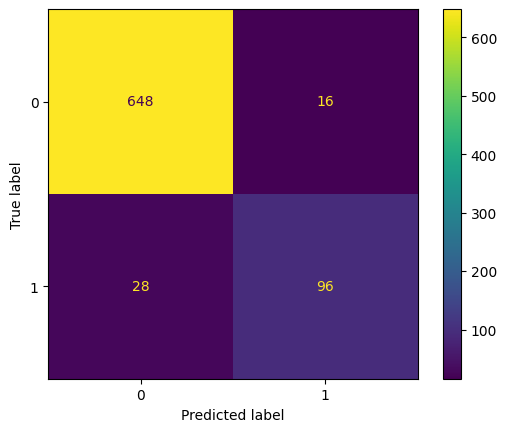

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


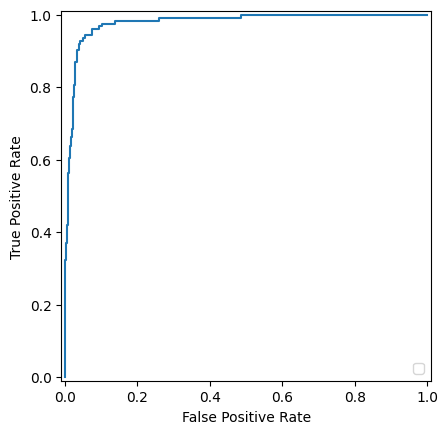

In [10]:
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_score, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()